In [26]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

DATA_DIR = 'data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print(f"Original Train Shape: {df_train.shape}")
print(f"Original Test Shape: {df_test.shape}")

Original Train Shape: (16209, 21)
Original Test Shape: (5404, 20)


Data Cleaning & Feature Engineering 

In [ ]:
# Handle Dates & Duplicates
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%dT%H%M%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y%m%dT%H%M%S')

df_train = df_train.sort_values('date', ascending=False).drop_duplicates('id', keep='first')

existing_images = set([f.split('.')[0] for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])

def filter_with_images(df, dataset_name):
    initial_count = len(df)
    df_filtered = df[df['id'].astype(str).isin(existing_images)].copy()
    final_count = len(df_filtered)
    print(f"[{dataset_name}] Filtered: {initial_count} -> {final_count} (Dropped {initial_count - final_count} missing images)")
    return df_filtered

df_train_clean = filter_with_images(df_train, "Train")
df_test_clean = filter_with_images(df_test, "Test")

# FEATURE ENGINEERING
# Feature 1: House Age (Standard)
df_train_clean['house_age'] = 2025 - df_train_clean['yr_built']
df_test_clean['house_age'] = 2025 - df_test_clean['yr_built']

# Feature 2: Is Renovated? (Binary 1/0)
# 'yr_renovated' is 0 if never renovated.
df_train_clean['is_renovated'] = (df_train_clean['yr_renovated'] > 0).astype(int)
df_test_clean['is_renovated'] = (df_test_clean['yr_renovated'] > 0).astype(int)

# Feature 3: Density (Living Space vs Lot Size)
df_train_clean['living_to_lot_ratio'] = df_train_clean['sqft_living'] / df_train_clean['sqft_lot']
df_test_clean['living_to_lot_ratio'] = df_test_clean['sqft_living'] / df_test_clean['sqft_lot']

print("\nNew Features Sample:")
print(df_train_clean[['price', 'house_age', 'is_renovated', 'living_to_lot_ratio']].head(5))

[Train] Filtered: 16110 -> 16110 (Dropped 0 missing images)
[Test] Filtered: 5404 -> 5404 (Dropped 0 missing images)

New Features Sample:
         price  house_age  is_renovated  living_to_lot_ratio
490     445500         84             0             0.208396
12866   450000         65             0             0.254630
11609  1695000         21             0             0.620097
3980    335000         40             0             0.031427
5432    479349         11             0             0.505886


Visual EDA (Price & Location)

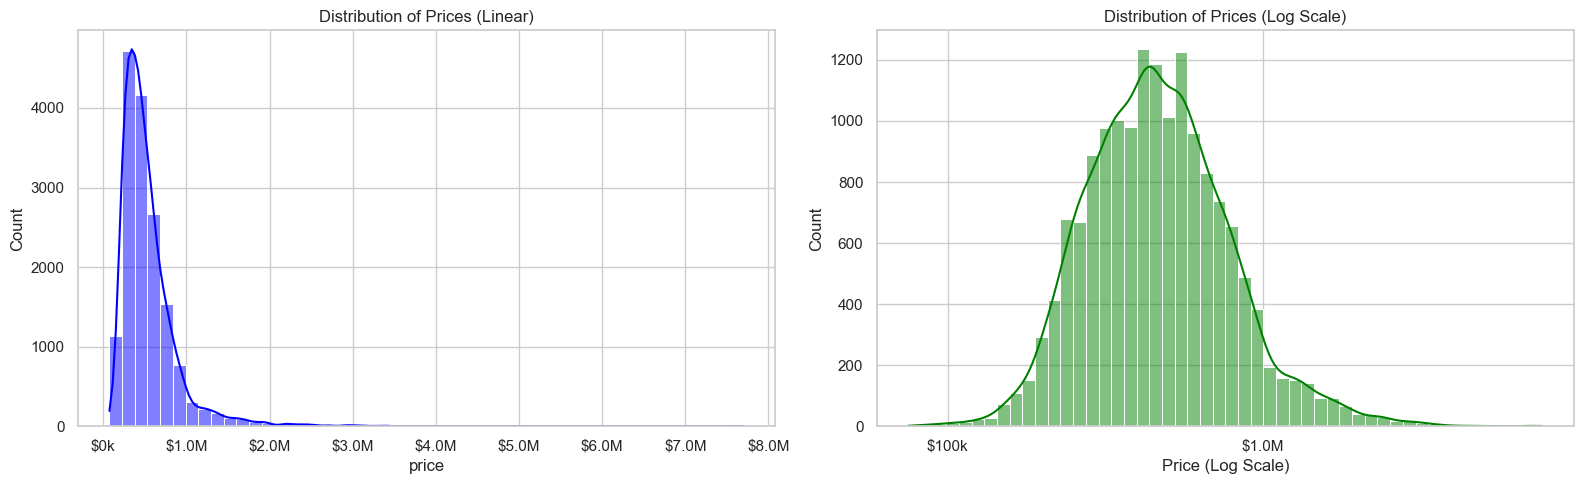

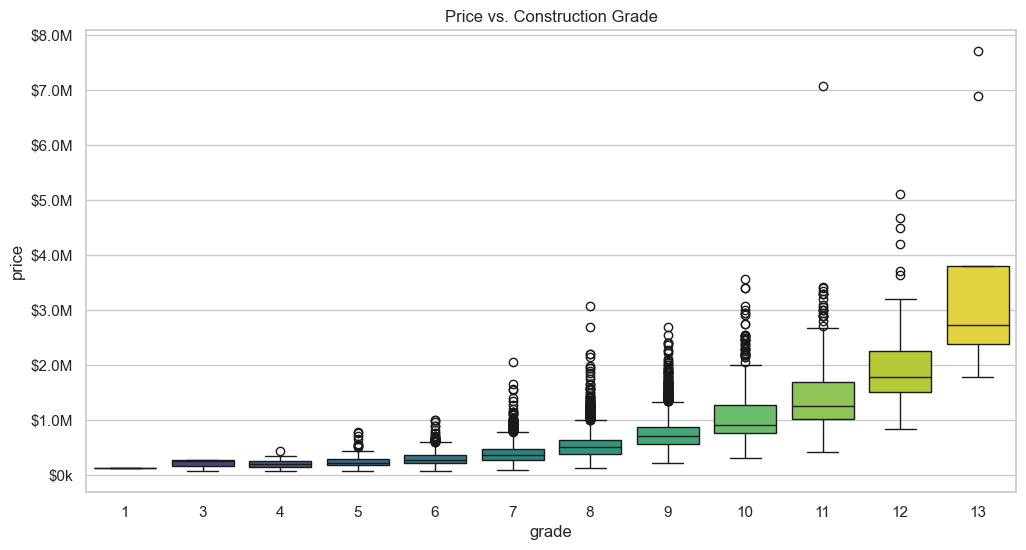

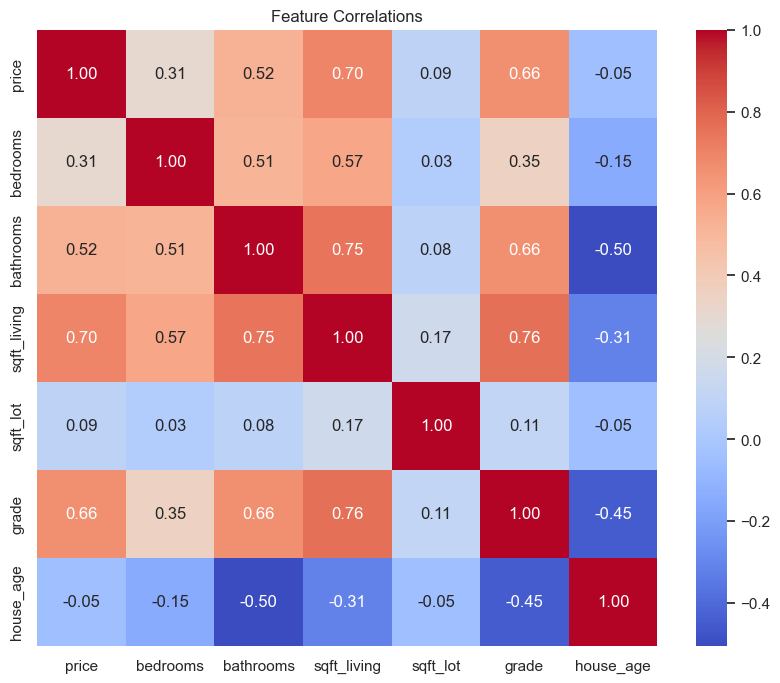

In [ ]:
from matplotlib.ticker import FuncFormatter

def currency_fmt(x, pos):
    if x >= 1_000_000:
        return f'${x*1e-6:.1f}M'
    return f'${x*1e-3:.0f}k'

formatter = FuncFormatter(currency_fmt)

# Set style
sns.set(style="whitegrid")

# 1. Price Distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot A: Standard Scale
sns.histplot(df_train_clean['price'], kde=True, bins=50, color='blue', ax=ax[0])
ax[0].set_title("Distribution of Prices (Linear)")
ax[0].xaxis.set_major_formatter(formatter)

# Plot B: Log Scale
sns.histplot(df_train_clean['price'], kde=True, bins=50, color='green', log_scale=True, ax=ax[1])
ax[1].set_title("Distribution of Prices (Log Scale)")
ax[1].set_xlabel("Price (Log Scale)")
ax[1].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# 2. Price vs Grade (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='grade', y='price', hue='grade', data=df_train_clean, palette="viridis", legend=False)
plt.title("Price vs. Construction Grade")
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

numeric_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'house_age']
plt.figure(figsize=(10, 8))
sns.heatmap(df_train_clean[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations")
plt.show()

Save Processed Data

In [ ]:
train_save_path = os.path.join(DATA_DIR, 'processed_train.csv')
test_save_path = os.path.join(DATA_DIR, 'processed_test.csv')

df_train_clean.to_csv(train_save_path, index=False)
df_test_clean.to_csv(test_save_path, index=False)

print(f"Saved processed data to:\n{train_save_path}\n{test_save_path}")

Saved processed data to:
data\processed_train.csv
data\processed_test.csv
